<h1 align=center>Capítulo 4 - Correspondência baseada em regras</h1>
<p align=center><img src=https://growvox.com/wp-content/uploads/2020/08/remarketing.png width=500></p>

**A extração de informações baseada em regras** é indispensável para qualquer pipeline de NLP. Certos tipos de entidades, como horas, datas e números de telefone, possuem formatos distintos que podem ser reconhecidos por um conjunto de regras, sem a necessidade de treinar modelos estatísticos.

Neste capítulo, você aprenderá a extrair rapidamente informações do texto combinando padrões e frases. Você usará **recursos morfológicos**, **tags POS**, **regex** e outros recursos spaCy para formar objetos padrão para alimentar os objetos **Matcher**. Você continuará com modelos estatísticos refinados com correspondência baseada em regras para elevar os modelos estatísticos a uma precisão melhor.

Ao final deste capítulo, você conhecerá uma parte vital da extração de informações. Você poderá extrair entidades de formatos específicos, bem como entidades específicas do seu domínio. Neste capítulo, abordaremos os seguintes tópicos principais:
* Correspondência baseada em token
* Phrase Matcher
* EntityRuler
* Combinando modelos spaCy e matchers

## Correspondência baseada em token
Até agora, exploramos os conceitos linguísticos sofisticados que requerem modelos estatísticos e seus usos com spaCy. Algumas tarefas NLU podem ser resolvidas de maneiras complicadas sem a ajuda de qualquer modelo estatístico. Uma dessas maneiras é o **regex**, que usamos para corresponder um conjunto predefinido de padrões ao nosso texto.

Uma regex (uma expressão regular) é uma sequência de caracteres que especifica um padrão de pesquisa. Uma regex descreve um conjunto de strings que segue o padrão especificado. Um regex pode incluir letras, dígitos e caracteres com significados especiais, como ?, . e *. A biblioteca interna do Python oferece excelente suporte para definir e combinar expressões regulares. Há outra biblioteca Python 3 chamada regex que pretende substituir **re** no futuro.

Os leitores que estão desenvolvendo ativamente aplicativos de PNL com Python definitivamente encontraram código regex e, melhor ainda, escreveram regex.

Como é uma regex, então? A regex a seguir corresponde às seguintes strings:
*Barack Obama
*Barack Obama
*Barack Hussein Obama
~~~python
reg = r"Barack\s(Hussein\s)?Obama"
~~~

Este padrão pode ser lido como: a string **Barack** pode ser seguida opcionalmente pela string **Hussein** (o caractere **?** em regex significa opcional, ou seja, **0** ou ** 1** ocorrência) e deve ser seguido pela string **Obama**. Os espaços entre palavras podem ser um único caractere de espaço, uma tabulação ou qualquer outro caractere de espaço em branco (**\s** corresponde a todos os tipos de caracteres de espaço em branco, incluindo o caractere de nova linha).

Não é muito legível, mesmo para um padrão tão curto e descomplicado, não é? Essa é a desvantagem do regex, é o seguinte:

* Difícil de ler
* Difícil de depurar
* Propenso a erros com espaço, pontuação e caracteres numéricos

Por esses motivos, muitos engenheiros de software não gostam de trabalhar com regex em seu código de produção. spaCy fornece uma alternativa muito limpa, legível, de nível de produção e de manutenção: a classe **Matcher**. A classe **Matcher** pode corresponder nossas regras predefinidas à sequência de tokens em objetos **Doc** e **Span**; além disso, as regras podem se referir ao token ou seus atributos linguísticos (mais sobre esse assunto posteriormente nesta seção).

Vamos começar com um exemplo básico de como chamar a classe **Matcher**:

In [4]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_md')
doc = nlp("Good morning, I want to reserve a ticket.")
matcher = Matcher(nlp.vocab)

pattern = [{"LOWER": "good"},
           {"LOWER": "morning"},
           {"IS_PUNCT": True}]

matcher.add("morningGreeting", [pattern])
matches = matcher(doc)

for match_id, start, end in matches:
	m_span = doc[start:end]
	print(start, end, m_span.text)


0 3 Good morning,


Parece complicado, mas não se intimide, vamos repassar as linhas uma a uma:
* Importamos **spacy** na primeira linha; isso deve ser familiar.
* Na segunda linha, importamos a classe **Matcher** para usá-la no restante do código.
* Nas próximas linhas, criamos o objeto **nlp** como de costume e criamos o objeto **doc** com nossa frase de exemplo.
* Agora, preste atenção: um objeto **matcher** precisa ser inicializado com um objeto **Vocabulary**, então na linha 5 inicializamos nosso objeto **matcher** com o vocabulário do modelo de linguagem (esta é a maneira usual de fazer isso). O que vem a seguir é definir o padrão que queremos combinar. Aqui, definimos padrão como uma lista onde cada item da lista dentro de uma chave representa um objeto token.

Você pode ler a lista de padrões no snippet de código anterior da seguinte maneira:
1. Um token cujo texto em minúsculo é **good**
2. Um token cujo texto em minúsculo é **morning**
3. Um token que é pontuação (ou seja, o recurso **IS_PUNCT** é **True**)

Em seguida, precisamos introduzir esse padrão ao **matcher**; é isso que a **linha matcher.add()** faz. Na linha 7, introduzimos nosso padrão no objeto **matcher** e nomeamos essa regra como **morningGreeting**. Finalmente, podemos fazer a operação de correspondência na linha 8 chamando **matcher** no **doc**. Depois disso, examinamos o resultado que obtemos. Um resultado de partida é uma lista tríplice no formato (**ID do match**, **posição inicial**, **posição final**). Na linha final, iteramos sobre a lista de resultados e imprimimos a posição inicial, a posição final e o texto da correspondência do resultado.

Como você pode ter notado, o espaço em branco entre **Good** e **morning** não importava nada. Na verdade, poderíamos ter colocado dois espaços em branco no meio, escrito **Good morning**, e o resultado seria idêntico. Por quê? Porque o **Matcher** corresponde aos tokens e aos atributos do token. Um padrão sempre se refere a uma sequência contínua de objetos simbólicos, e cada item nas chaves corresponde a um objeto simbólico. Vamos voltar ao padrão no trecho de código anterior:

~~~python
pattern = [{"LOWER": "good"}, {"LOWER": "morning"},{"IS_PUNCT": True}]
~~~
Vemos que o resultado é sempre uma partida de três fichas.

Podemos adicionar mais de um padrão? A resposta é sim. Vamos ver com um exemplo e também ver um exemplo de **match_id** da seguinte forma:

In [7]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_md")
doc = nlp("Good morning, I want to reserve a ticket. I will then say good evening!")
matcher = Matcher(nlp.vocab)

pattern1 = [
	{"LOWER": "good"},
	{"LOWER": "morning"},
	{"IS_PUNCT": True}
]

matcher.add("morningGreeting", [pattern1])

pattern2 = [
	{"LOWER": "good"},
	{"LOWER": "evening"},
	{"IS_PUNCT": True}
]

matcher.add("eveningGreeting", [pattern2])

matches = matcher(doc)

for match_id, start, end in matches:
	pattern_name = nlp.vocab.strings[match_id]
	m_span = doc[start:end]
	print(pattern_name, start, end, m_span.text)

morningGreeting 0 3 Good morning,
eveningGreeting 14 17 good evening!


Desta vez fizemos as coisas de forma um pouco diferente:
* Na linha 8, definimos um segundo padrão, novamente combinando três tokens, mas desta vez **evening** em vez de **morning**.
* Na próxima linha, adicionamos ao **matcher**. Neste ponto, o **matcher** contém 2 padrões: **morningGreeting** e **eveningGreeting**.
* Novamente, chamamos o **matcher** em nossa sentença e examinamos o resultado. Desta vez, a lista de resultados tem dois itens, **Good morning** e **good evening!**, correspondendo a dois padrões diferentes, **morningGreeting** e **eveningGreeting**.

No exemplo de código anterior, **pattern1** e **pattern2** diferem apenas por um token: **evening/morning**. Em vez de escrever dois padrões, podemos dizer **evening** ou **morning**? Podemos fazer isso também.

Aqui estão os atributos que o Matcher reconhece:

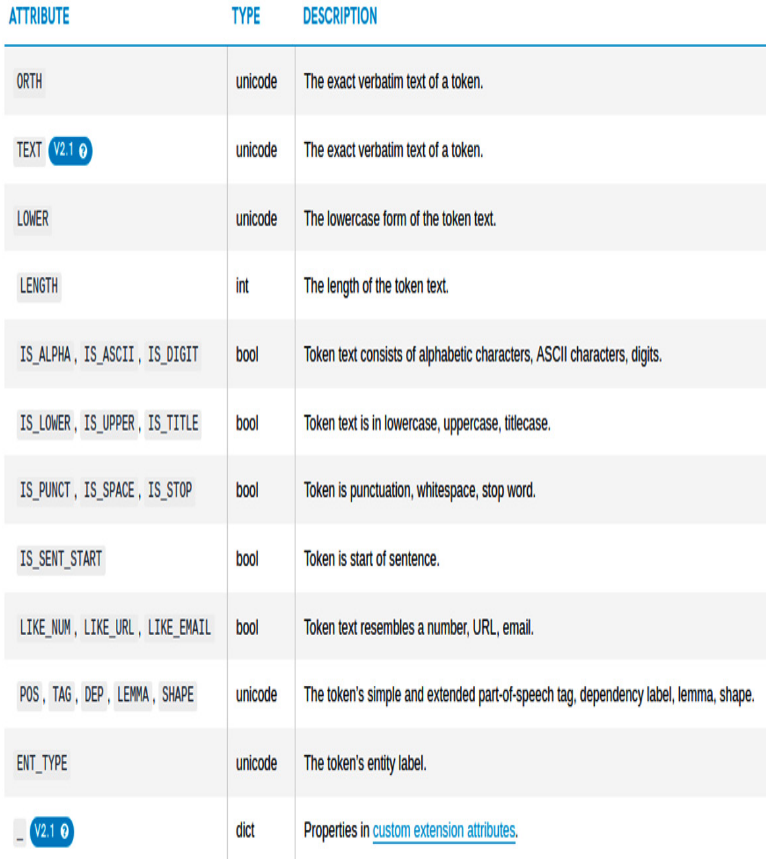

In [8]:
from IPython.display import Image
Image('images/matcher_attributes.PNG')

Vamos examinar os atributos um por um com alguns exemplos. Usamos **LOWER** nos exemplos anteriores; significa a forma minúscula do texto do token. **ORTH** e **TEXT** são semelhantes a **LOWER**: significam uma correspondência exata do texto do token, incluindo maiúsculas e minúsculas. Aqui está um exemplo:
~~~python
pattern = [{"TEXT": "Bill"}]
~~~

O código anterior corresponderá a **BIll**, mas não a **bill**. **LENGTH** é usado para especificar o comprimento do token. O código a seguir encontra todos os tokens de comprimento **1**:

In [10]:
doc = nlp("I bought a pineapple.")
matcher = Matcher(nlp.vocab)
pattern = [{"LENGTH": 1}]
matcher.add("onlyShort", [pattern])
matches = matcher(doc)
for mid, start, end in matches:
    print(start, end, doc[start:end])

0 1 I
2 3 a
4 5 .


O próximo bloco de atributos de token é **IS_ALPHA**, **IS_ASCII** e **IS_DIGIT**. Esses recursos são úteis para encontrar tokens numéricos e palavras *comuns* (que não incluem caracteres interessantes). O padrão a seguir corresponde a uma sequência de dois tokens, um número seguido por uma palavra comum:

In [11]:
doc1 = nlp("I met him at 2 o'clock.")
doc2 = nlp("He brought me 2 apples.")
pattern = [{"IS_DIGIT": True},{"IS_ALPHA": True}]
matcher.add("numberAndPlainWord", [pattern])
matcher(doc1)

[(6199552685565397078, 0, 1),
 (6199552685565397078, 4, 5),
 (6199552685565397078, 6, 7)]

In [12]:
matches = matcher(doc2)
len(matches)

3

In [13]:
mid, start, end = matches[0]
print(start, end, doc2[start:end])

3 4 2
